In [22]:
import os
import sys

# Add the project root to the Python path
# This assumes the notebook is in the 'exp' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root added to path: {project_root}")

Project root added to path: /media/john/Tertiary/Projects/ML/BayesianFlowNet


In [23]:
from torch import Tensor
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from math import log
import einops

from src.nn.layers.learnable_schedule import LearnableBetaScheduleNI
from src.datasets.discrete_helper import y_distribution

In [24]:
def divergence_loss(
    x: Tensor,
    schedule: LearnableBetaScheduleNI,
    folds: int,
    samples: int = 64,
) -> Tensor:
    """
    Divergence loss is a regularization term that is intended to help train
    the learnable schedule. As noted in the paper, at timestep `t = 1.0`, the
    input distribution should approach the ground truth `x`. Minimizing the loss
    tends to drive the model towards a degenerate solution.

    As such, we must penalize the schedule to ensure that its `beta` output at
    `t = 1.0` is large enough such that, when the input distribution is perturbed
    as a function of `beta`, it is approximately equal to the ground truth

    For more information, see https://arxiv.org/pdf/2308.07037 equation 69

    Looking at section 6.8, we see that we actually want the entropy to decrease
    linearly with time. At `t=0.0` we have maximum entropy (ln(K)) while at
    `t=1.0` we have minimum entropy (0). Note that due to Jensen's inequality,
    we will need to use Monte Carlo sampling to estimate the entropy of the
    distribution

    Args:
        x: Ground truth tensor of shape (batch_folds, seq_len, K).
        schedule: Learnable beta schedule.
        folds: Number of folds used for loss variance estimation.
        samples: Number of Monte Carlo samples to use for entropy estimation.
    Returns:
        Divergence loss tensor.
    """

    batch_folds, seq_len, K = x.shape
    assert (
        batch_folds % folds == 0
    ), f"batch_folds {batch_folds} must be divisible by folds {folds}"
    batch_size = batch_folds // folds

    t = torch.rand(batch_folds, device=x.device)
    t.requires_grad_(True)

    beta_t = schedule.forward(t, K)

    assert not torch.isnan(beta_t).any(), f"Beta schedule got {beta_t} at time {t}"
    assert not torch.isinf(beta_t).any(), f"Beta schedule got {beta_t} at time {t}"

    beta_t_expanded = einops.repeat(
        beta_t,
        "(b f) -> (b f s)",
        b=batch_size,
        f=folds,
        s=samples,
    )

    x_expanded = einops.repeat(
        x,
        "(b f) seq K -> (b f s) seq K",
        b=batch_size,
        f=folds,
        s=samples,
    )

    logits = y_distribution(beta_t_expanded, K, x_expanded)
    
    # Using torch.distributions.Categorical is slow
    # entropy = Categorical(logits=logits).entropy()
    # A numerically stable way to compute entropy
    p = F.softmax(logits, dim=-1)
    log_p = F.log_softmax(logits, dim=-1)
    entropy = -torch.sum(p * log_p, dim=-1)


    expected_entropy = einops.reduce(
        entropy,
        "(b f s) seq -> (b f)",
        "mean",
        b=batch_size,
        f=folds,
        s=samples,
    )

    target_entropy = log(K) * (1 - t)

    return F.mse_loss(expected_entropy, target_entropy, reduction="mean")

In [25]:
class TokenizerBase:
    def vocab_size(self) -> int:
        raise NotImplementedError("This method should be implemented by subclasses.")

    def encode(self, text: str) -> Tensor:
        raise NotImplementedError("This method should be implemented by subclasses.")

    def decode(self, tokens: Tensor) -> str:
        raise NotImplementedError("This method should be implemented by subclasses.")

class DiscreteSyntheticTokenizer(TokenizerBase):
    def __init__(self):
        super().__init__()
        self.vocab = {",": 10}
        for i in range(10):
            self.vocab[str(i)] = i
        self.anti_vocab = {v: k for k, v in self.vocab.items()}

    def vocab_size(self) -> int:
        return len(self.vocab)

    def encode(self, text: str) -> Tensor:
        splits = text.split()
        res = [self.vocab.get(s, 0) for s in splits]
        return torch.tensor(res, dtype=torch.long)

    def decode(self, tokens: Tensor) -> str:
        assert tokens.ndim == 2
        seq_len, K = tokens.shape
        cur_seq = []
        for i in range(seq_len):
            value = torch.argmax(tokens[i])
            cur_seq.append(self.anti_vocab.get(value.item(), ""))
        return " ".join(cur_seq)

In [26]:
class DiscreteSyntheticDataset(Dataset):
    def __init__(
        self,
        tokenizer: DiscreteSyntheticTokenizer,
        length: int = 32,
        tokenized_length: int = 32,
        mini: int = 0,
        maxi: int = 100,
    ):
        self.length = length
        self.tokenized_length = tokenized_length
        self.tokenizer = tokenizer
        self.mini = mini
        self.maxi = maxi

    def generate_sequence(self):
        start = random.randint(self.mini, self.maxi - self.length)
        end = start + self.length
        acc = ""
        for i in range(start, end + 1):
            for c in str(i):
                acc += " " + c
            acc += " ,"
        tokenized = self.tokenizer.encode(acc)
        return tokenized[: self.tokenized_length]

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        seq = F.one_hot(
            self.generate_sequence(), num_classes=self.tokenizer.vocab_size()
        )
        return {"x": seq}

def collate_fn(batch):
    x = [item["x"] for item in batch]
    min_length = min(seq.shape[0] for seq in x)
    x = [tensor[:min_length] for tensor in x]
    x = torch.stack(x, dim=0)
    return {"x": x}

In [27]:
# Training setup
tokenized_length = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
folds = 4
batch_size = 8

# Initialize tokenizer and dataset
tokenizer = DiscreteSyntheticTokenizer()
dataset = DiscreteSyntheticDataset(
    tokenizer=tokenizer, length=tokenized_length * 2, tokenized_length=tokenized_length
)

# Create data loader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Initialize learnable beta schedule
schedule = LearnableBetaScheduleNI(reference_beta_1=1.8, learner_weight=1.0)
schedule = schedule.to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(schedule.parameters(), lr=1e-4)

print(f"Schedule parameters: {sum(p.numel() for p in schedule.parameters()):,}")
print(f"Vocab size: {tokenizer.vocab_size()}")
print(f"Dataset size: {len(dataset)}")

Schedule parameters: 66,690
Vocab size: 11
Dataset size: 10000


In [28]:
def train_schedule_only(num_epochs):
    schedule.train()
    train_iter = iter(dataloader)
    losses = []

    pbar = tqdm(range(num_epochs), desc="Training Schedule")

    for epoch in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(dataloader)
            batch = next(train_iter)

        x = batch["x"].to(device)
        
        # Repeat x for folds
        x = x.repeat(folds, 1, 1)

        loss = divergence_loss(x, schedule, folds=folds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.4f}")

    print("Training completed!")
    
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Divergence Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

Training Schedule:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed!


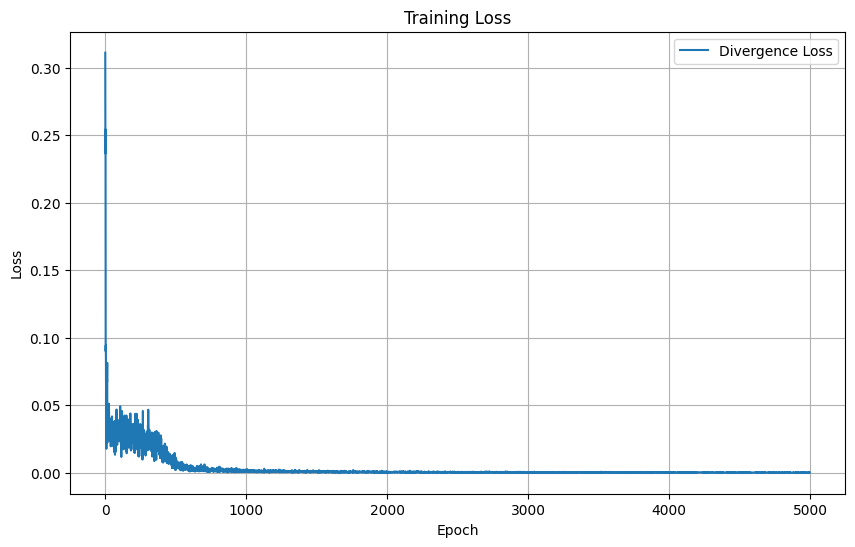

In [29]:
train_schedule_only(num_epochs=5000)

Learnt beta_1: 1.4223


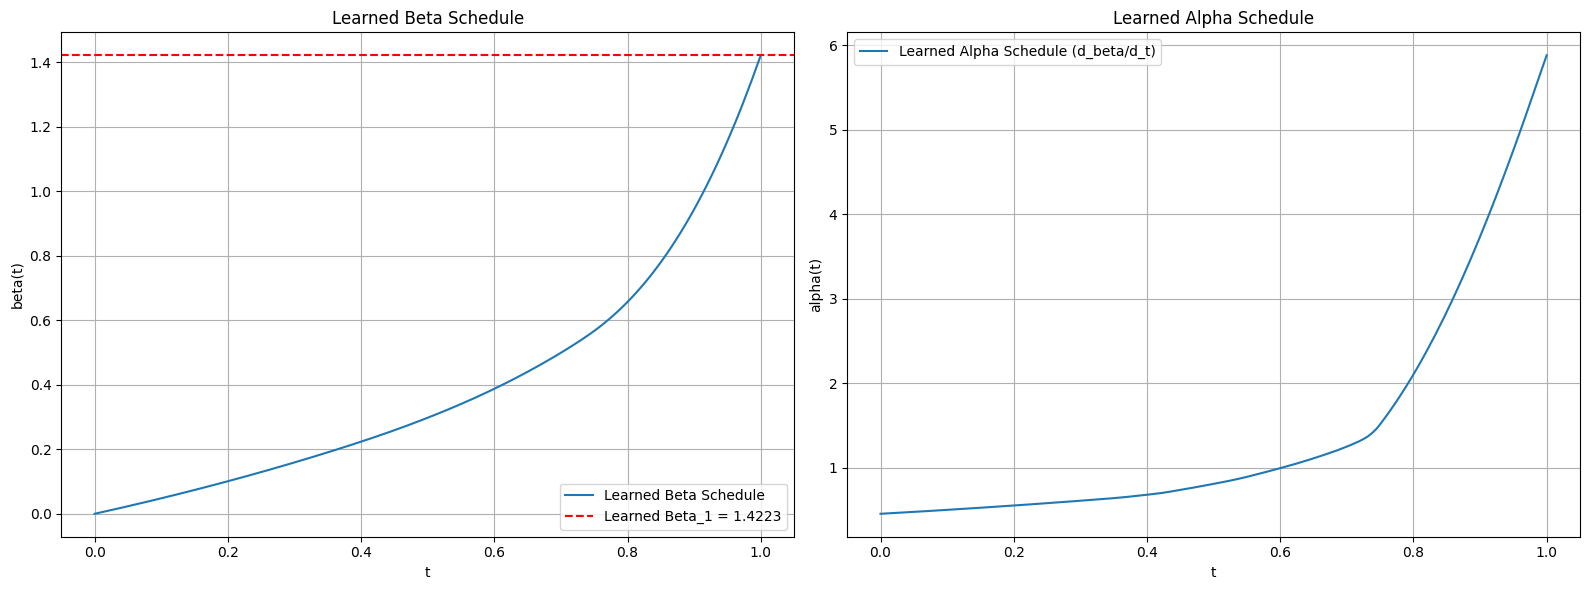

In [30]:
# Visualize the learned schedule
schedule.eval()
K = tokenizer.vocab_size()
t_values, beta_values = schedule.visualize(K=K, device=device)
t_values_alpha, alpha_values = schedule.visualize_alpha(K=K, device=device)
learnt_beta_1 = schedule.beta_1(K=K, device=device)

print(f"Learnt beta_1: {learnt_beta_1:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(t_values, beta_values, label="Learned Beta Schedule")
ax1.axhline(y=learnt_beta_1, color='r', linestyle='--', label=f'Learned Beta_1 = {learnt_beta_1:.4f}')
ax1.set_xlabel("t")
ax1.set_ylabel("beta(t)")
ax1.set_title("Learned Beta Schedule")
ax1.legend()
ax1.grid(True)

ax2.plot(t_values_alpha, alpha_values, label="Learned Alpha Schedule (d_beta/d_t)")
ax2.set_xlabel("t")
ax2.set_ylabel("alpha(t)")
ax2.set_title("Learned Alpha Schedule")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

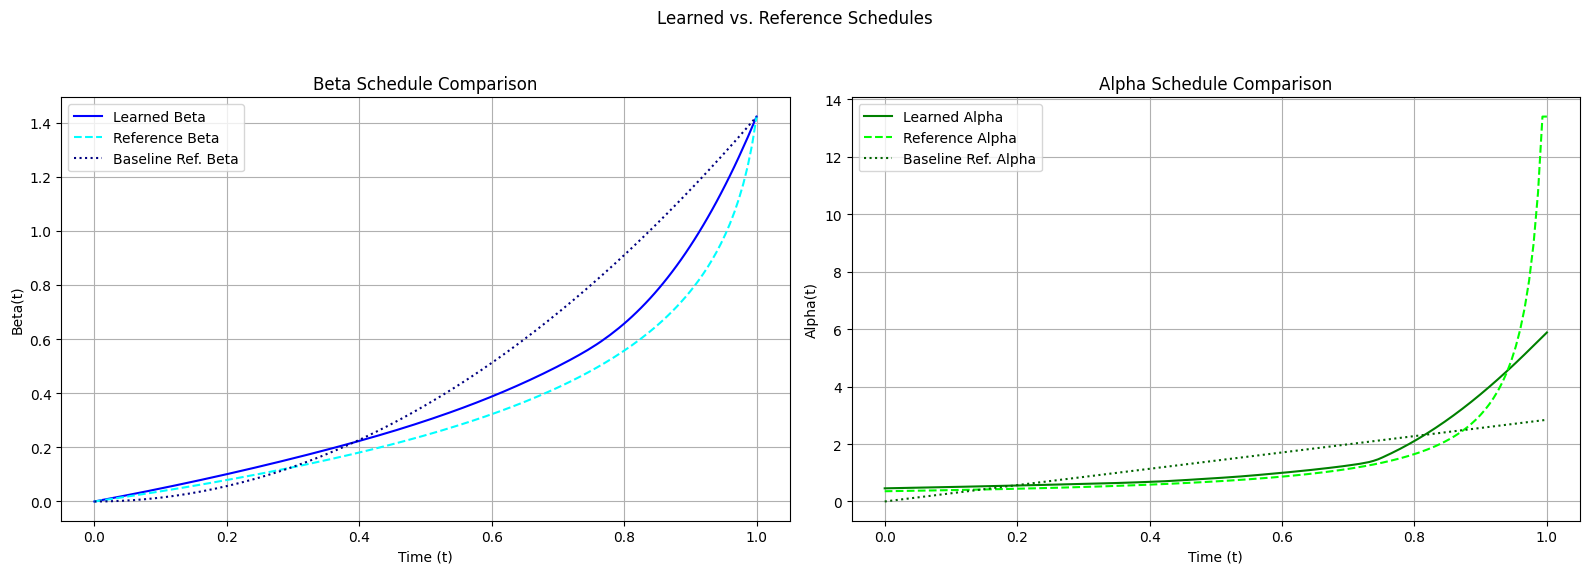

In [31]:
# from chem bfn paper
def reference_beta_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (- 4 / K) * torch.log(1 - t + t * torch.exp(- K * beta_1 / 4))
def reference_alpha_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (4 / K) * ((1 - torch.exp(-K * beta_1 / 4)) / (1 - t + t * torch.exp(-K * beta_1 / 4)))

# from original bfn paper
def reference_beta_schedule_baseline(t: Tensor, K: int, beta_1: float) -> Tensor:
    return beta_1 * (t ** 2)
def reference_alpha_schedule_baseline(t: Tensor, K: int, beta_1: float) -> Tensor:
    return beta_1 * 2 * t

ref_beta = reference_beta_schedule(torch.as_tensor(t_values, device=device), tokenizer.vocab_size(), torch.tensor([learnt_beta_1], device=device))
ref_alpha = reference_alpha_schedule(torch.as_tensor(t_values_alpha, device=device), tokenizer.vocab_size(), torch.tensor([learnt_beta_1], device=device))
ref_alpha[-1] = ref_alpha[-2]  # avoid tiny numerical issues at t=1, the graph looks useless otherwise
ref_beta_baseline = reference_beta_schedule_baseline(torch.as_tensor(t_values, device=device), tokenizer.vocab_size(), torch.tensor([learnt_beta_1], device=device))
ref_alpha_baseline = reference_alpha_schedule_baseline(torch.as_tensor(t_values_alpha, device=device), tokenizer.vocab_size(), torch.tensor([learnt_beta_1], device=device))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Learned vs. Reference Schedules')

# Beta schedule comparison
ax1.plot(t_values, beta_values, label='Learned Beta', color='blue')
ax1.plot(t_values, ref_beta.cpu().numpy(), label='Reference Beta', color='cyan', linestyle='--')
ax1.plot(t_values, ref_beta_baseline.cpu().numpy(), label='Baseline Ref. Beta', color='navy', linestyle=':')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Beta Schedule Comparison')
ax1.legend()
ax1.grid(True)

# Alpha schedule comparison
ax2.plot(t_values_alpha, alpha_values, label='Learned Alpha', color='green')
ax2.plot(t_values_alpha, ref_alpha.cpu().numpy(), label='Reference Alpha', color='lime', linestyle='--')
ax2.plot(t_values_alpha, ref_alpha_baseline.cpu().numpy(), label='Baseline Ref. Alpha', color='darkgreen', linestyle=':')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Alpha Schedule Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

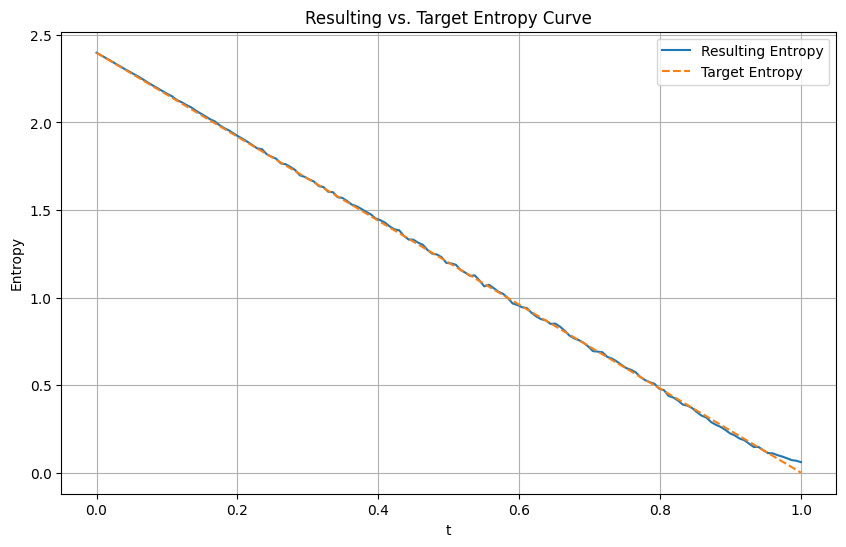

In [33]:
# Visualize the entropy curve
schedule.eval()
K = tokenizer.vocab_size()
points = 150
t_values = torch.linspace(0.0, 1.0, points, device=device)

# Get a sample from the dataset
batch = next(iter(dataloader))
x = batch["x"].to(device)
if x.shape[0] > 1:
    x = x[:1] # Use a single sample for visualization

x = x.repeat(points, 1, 1) # Repeat for each t value

beta_t = schedule.forward(t_values, K)

samples = 128
beta_t_expanded = einops.repeat(
    beta_t,
    "p -> (p s)",
    s=samples,
)
x_expanded = einops.repeat(
    x,
    "p seq K -> (p s) seq K",
    s=samples,
)

logits = y_distribution(beta_t_expanded, K, x_expanded)
p = F.softmax(logits, dim=-1)
log_p = F.log_softmax(logits, dim=-1)
entropy = -torch.sum(p * log_p, dim=-1)

expected_entropy = einops.reduce(
    entropy,
    "(p s) seq -> p",
    "mean",
    s=samples,
)

target_entropy = log(K) * (1 - t_values)

plt.figure(figsize=(10, 6))
plt.plot(t_values.cpu().numpy(), expected_entropy.cpu().detach().numpy(), label="Resulting Entropy")
plt.plot(t_values.cpu().numpy(), target_entropy.cpu().detach().numpy(), label="Target Entropy", linestyle='--')
plt.xlabel("t")
plt.ylabel("Entropy")
plt.title("Resulting vs. Target Entropy Curve")
plt.legend()
plt.grid(True)
plt.show()